<a href="https://colab.research.google.com/github/wilberquito/Thesis/blob/main/Code/nn/notebooks/resnet18/ResNet18_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet18, V1

In [1]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
from zipfile import ZipFile

try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
In colab: True


In [2]:
def pull_code():
  print("Unzipping the code from google drive")
  !rm -rf modular/
  !unzip ./drive/MyDrive/modular.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_code() 

Unzipping the code from google drive


In [3]:
def pull_data():
  answer = input("You sure? Y/n\n")
  if answer != "Y":
    return

  print("Unzipping the data from google drive")
  !rm -rf data.etl/
  !unzip ./drive/MyDrive/data.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_data() 

You sure? Y/n
Y
Unzipping the data from google drive


In [ ]:
!nvidia-smi

Fri May 19 13:46:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Scheduler

In [3]:
LEARNING_RATE = 1e-3
EPOCHS = 25
STEP_SIZE = 15

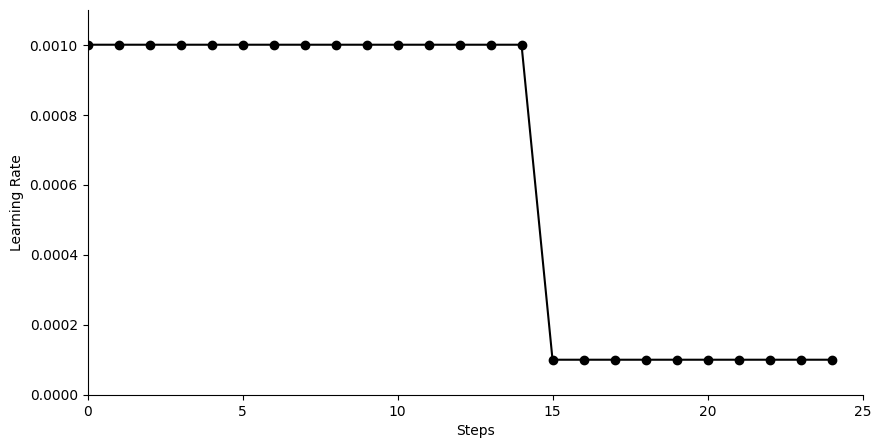

In [4]:
import torch
import torch.optim.lr_scheduler as lr_scheduler # Import your choice of scheduler here

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Set model and optimizer
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Define your scheduler here as described above
# ...
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

# Get learning rates as each training step
learning_rates = []

for i in range(EPOCHS):
    optimizer.step()
    learning_rates.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

# Visualize learinig rate scheduler
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(range(EPOCHS), 
        learning_rates,
        marker='o', 
        color='black')
ax.set_xlim([0, EPOCHS])
ax.set_ylim([0, LEARNING_RATE + 0.0001])
ax.set_xlabel('Steps')
ax.set_ylabel('Learning Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Writter

In [6]:
import modular.utility as m_utility
writter = m_utility.model_writter('resnet18_v1')

## Fine Tunning

In [ ]:
## Try a Resnet prediction
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import modular.engine as engine
from torchvision.models import (ResNet18_Weights)
from torch.utils.data import DataLoader
import torch
import modular.dataset as m_dataset
import modular.utility as m_utility
from torchvision import transforms

# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, test_df, mapping = m_dataset.get_df(data_dir, data_folder)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(mapping))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=0.1)


# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.15)


train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validate_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = m_dataset.MelanomaDataset(train_df,
                                          mode='train',
                                          transform=train_transform,
                                          idx_to_class=idx_to_class)                                                       
validate_dataset = m_dataset.MelanomaDataset(validate_df,
                                             mode='validate',
                                             transform=validate_transform,
                                             idx_to_class=idx_to_class)                                                       

batch_size = 512                                             

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

# Test dataset and dataloader
test_dataset = m_dataset.MelanomaDataset(test_df,
                                         mode='test',
                                         idx_to_class=idx_to_class)                                                       
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Dataloaders
train_dataloaders = {
    'train': train_dataloader,
    'val': validate_dataloader,
}

train_dataloaders_size = {
    'train': len(train_dataset),
    'val': len(validate_dataset),
}

model_ft = engine.train_model(model_ft, 
                              train_dataloaders,
                              train_dataloaders_size,
                              device,
                              criterion, 
                              optimizer_ft, 
                              exp_lr_scheduler,
                              num_epochs=25,
                              writter=writter)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


Epoch 1/25
----------


In [ ]:
model_ft[1].keys()

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])